# Add known locations to `cartopy` plots

In my [previous][notebook-link] notebook, I was able to adapt [code][blaylock-link] from Brian Blaylock to plot AOD data using `cartopy`. In this notebook I will attempt to add some known locations, such as state capitols, to our AOD plots as points. This will serve as a stepping stone towards overlaying monitors (colored by AQI value) on top of the AOD plots.

## Goal

Given a set of known locations, plot each location as a point on the AOD plot from the previous notebook.

[notebook-link]: ./plot_aod_data_with_cartopy_2019-04-04.ipynb
[blaylock-link]: https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_TrueColor_Cartopy.ipynb

## Recreate AOD plot from previous notebook

First, lets recreate the plot from the previous notebook to overlay known locations onto.

In [14]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys

In [2]:
# First, just load the AOD data
# -----------------------------

BASEPATH = '../../local_data/'
FILE = 'OR_ABI-L2-AODC-M3_G16_s20190781512186_e20190781514559_c20190781516459.nc'

C = xarray.open_dataset(BASEPATH+FILE)

In [3]:
# Extract date and time information
# ---------------------------------

# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
# I'm not a fan of numpy datetime, so I convert it to a regular datetime object
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

In [4]:
# Get AOD and get a little information about it
# ---------------------------------------------

AOD = C['AOD'].data

print("AOD is a {}".format(type(AOD)))
print("AOD has shape {}".format(AOD.shape))
print("AOD has a valid range of {}".format(C['AOD'].valid_range))
print("min(AOD) = {}".format(np.nanmin(AOD)))  # ignore NaNs
print("max(AOD) = {}".format(np.nanmax(AOD)))

AOD is a <class 'numpy.ndarray'>
AOD has shape (1500, 2500)
AOD has a valid range of [ 0 -6]
min(AOD) = -0.05000000074505806
max(AOD) = 4.999972820281982


In [5]:
# Extract projection information
# ------------------------------

# Satellite height
sat_h = C['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C['goes_imager_projection'].sweep_angle_axis

semi_major = C['goes_imager_projection'].semi_major_axis
semi_minor = C['goes_imager_projection'].semi_minor_axis

# The projection x and y coordinates equals the scanning angle (in radians)
# multiplied by the satellite height See details here:
# https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C['x'][:] * sat_h
y = C['y'][:] * sat_h

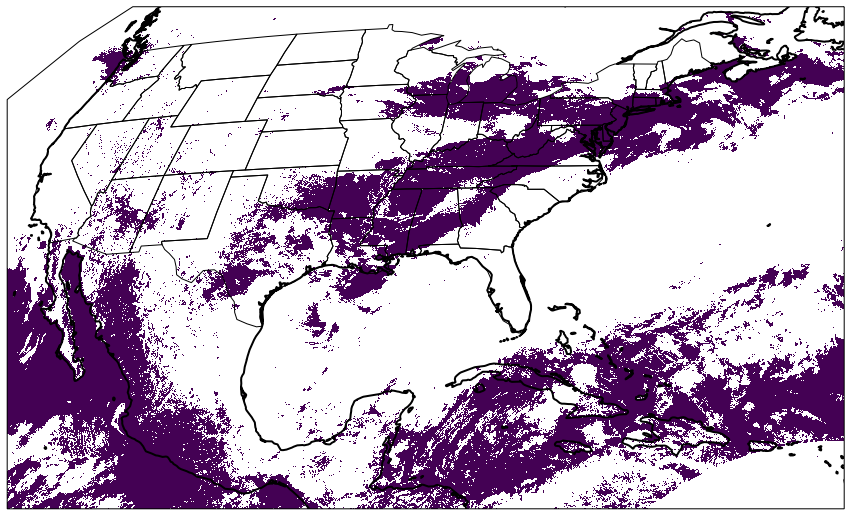

In [6]:
fig = plt.figure(figsize=(15, 12))

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)

geos = ccrs.Geostationary(central_longitude=sat_lon, 
                         satellite_height=sat_h, globe=globe)

ax = fig.add_subplot(1, 1, 1, projection=geos)

ax.imshow(np.flipud(AOD), origin='lower', 
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos,
          interpolation='nearest', vmin=162., vmax=330.)
ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.add_feature(ccrs.cartopy.feature.STATES)

This map is modified slightly from the one produced in the previous notebook.
* I changed the extent of the map to better fit our data
* I used a Plate Carree projection instead of Lambert Conformal
* I added a stock image provided by `cartopy`, just for fun

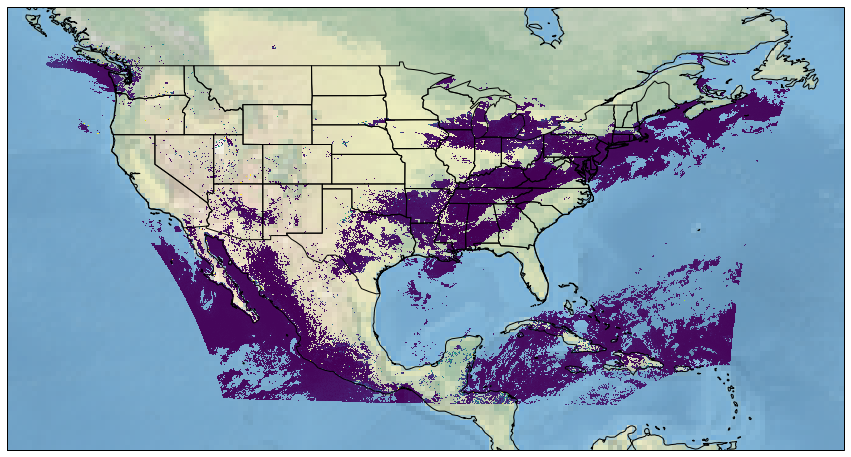

In [13]:
# Reproject to Plate Carree
# -------------------------

fig = plt.figure(figsize=(15, 12))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# set the extent (x0, x1, y0, y1) of the map in the given 
ax.set_extent([-135, -50, 10, 55], crs=ccrs.PlateCarree())

ax.stock_img()

ax.imshow(np.flipud(AOD), origin='lower',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos,
          interpolation='none')

ax.coastlines(resolution="50m")
ax.add_feature(ccrs.cartopy.feature.STATES)

## Now, add some known locations!

Lets try and add some known locations to the map above. I found a [csv of state capitals][state-capital-csv-link] that I am going to try and add using methods from [this][cartopy-tutorial-link] `cartopy` tutorial.

[state-capital-csv-link]: https://raw.githubusercontent.com/jasperdebie/VisInfo/master/us-state-capitals.csv
[cartopy-tutorial-link]: https://scitools.org.uk/cartopy/docs/latest/matplotlib/intro.html

In [22]:
# load capitals data as pandas dataframe and print some info
df_capitals = pd.read_csv("../../local_data/us_state_capitals.csv")

print("Columns: {}".format(list(df_capitals.columns)))
print("Shape: {}".format(df_capitals.shape))

Columns: ['name', 'description', 'latitude', 'longitude']
Shape: (50, 4)


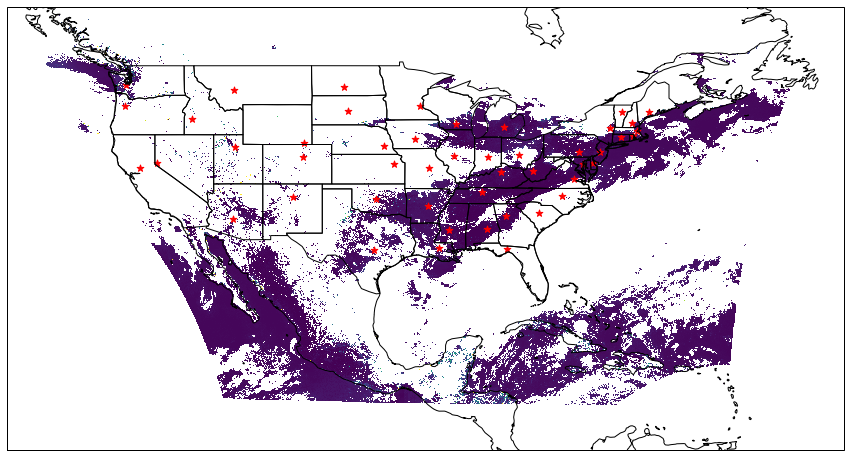

In [35]:
# Add state capitals
# ------------------

# --- start with the same code as above ---

fig = plt.figure(figsize=(15, 12))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# set the extent (x0, x1, y0, y1) of the map in the given 
ax.set_extent([-135, -50, 10, 55], crs=ccrs.PlateCarree())

# ax.stock_img()

ax.imshow(np.flipud(AOD), origin='lower',
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos,
          interpolation='none')

ax.coastlines(resolution="50m")
ax.add_feature(ccrs.cartopy.feature.STATES)

# --- add state capitals points ---

ax.scatter(df_capitals["longitude"], df_capitals["latitude"],
           s=50,color="red", marker="*", )

#ax.set_title("GOES 16 AOD and State Capitals", fontweight="semibold", position="right")
#ax.set_title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');

**Success!**  

The state capitals overlayed above seem to be all in the right position, and we should be able to use the same techiques to plot some monitors on top of the AOD data.

## Sources:

State capital csv: https://raw.githubusercontent.com/jasperdebie/VisInfo/master/us-state-capitals.csv  
Cartopy matplotlib integration reference: https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/geoaxes.html  
Cartopy projection list: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html#cartopy-projections  
Cartopy/Matplotlib tutorial: https://scitools.org.uk/cartopy/docs/latest/matplotlib/intro.html  